# 1. Setup

In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

In [ ]:
# Uncompress Tar GZ labelled Fases in the Wild Dataset
!tar -xf lfw.tgz

In [ ]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [6]:
# Import UUID library to generate unique image names
import uuid # universaly unique identifiers

In [ ]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    # Show image back to screen
    frame = frame[120:120+250,200:200+250,:]
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # create a unique file path
        imgname = os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        # write out positive image
        cv2.imwrite(imgname, frame)
    
    # Collect anchor
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # create a unique file path
        imgname = os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        # write out anchor image
        cv2.imwrite(imgname, frame)
    
    cv2.imshow('Image Collection', frame)
    
    # Breaking
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()

# Close the image collection frame
cv2.destroyAllWindows()

In [ ]:
frame.shape

# 3. Data Augmentation

In [7]:
def data_aug(img):
    data = []
    for i in range(15):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
#         img = tf.image.stateless_random_crop(img, size=(200,200,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
        data.append(img)
    
    return data

In [8]:
string1 = 'Kshitij'
string2 = 'Saurabh'
string3 = 'Jose'

In [9]:
for file_name in os.listdir(os.path.join(ANC_PATH,string1)):
    img_path = os.path.join(ANC_PATH,string1, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img)

    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, string1, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [10]:
for file_name in os.listdir(os.path.join(POS_PATH,string1)):
    img_path = os.path.join(POS_PATH, string1, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, string1, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 4. Load and Preprocess Images

In [6]:
# getting the paths of each of the image from all the 3 folders
anchor1 = tf.data.Dataset.list_files(os.path.join(ANC_PATH, 'Kshitij')+'\*.jpg').take(800)
positive1 = tf.data.Dataset.list_files(os.path.join(POS_PATH, 'Kshitij')+'\*.jpg').take(800)
negative1 = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(800)

anchor2 = tf.data.Dataset.list_files(os.path.join(ANC_PATH, 'Saurabh')+'\*.jpg').take(300)
positive2 = tf.data.Dataset.list_files(os.path.join(POS_PATH, 'Saurabh')+'\*.jpg').take(300)
negative2 = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

anchor3 = tf.data.Dataset.list_files(os.path.join(ANC_PATH, 'Jose')+'\*.jpg').take(150)
positive3 = tf.data.Dataset.list_files(os.path.join(POS_PATH, 'Jose')+'\*.jpg').take(150)
negative3 = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(150)

anchor4 = tf.data.Dataset.list_files(os.path.join(ANC_PATH, 'Ravi')+'\*.jpg').take(250)
positive4 = tf.data.Dataset.list_files(os.path.join(POS_PATH, 'Ravi')+'\*.jpg').take(250)
negative4 = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(250)

In [7]:
(os.path.join(ANC_PATH,'Kshitij')+'\*.jpg')

'data\\anchor\\Kshitij\\*.jpg'

In [10]:
dir_test = anchor1.as_numpy_iterator()

In [11]:
print(dir_test.next())

b'data\\anchor\\Kshitij\\927ff75a-c8b2-11ec-9b6b-90ccdf07571e.jpg'


In [12]:
def preprocess(file_path):
    
    # Read in image from file path like a byte like object
    byte_img = tf.io.read_file(file_path)
    
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [13]:
img = preprocess(b'data\\anchor\\Kshitij\\927ff75a-c8b2-11ec-9b6b-90ccdf07571e.jpg')

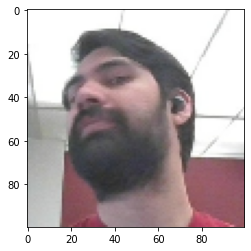

In [14]:
plt.imshow(img)

In [15]:
img.numpy().min()

0.16887255

In [16]:
img.numpy().max()

1.0

In [17]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [19]:
positives = tf.data.Dataset.zip((anchor1, positive1, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor1)))))
negatives = tf.data.Dataset.zip((anchor1, negative1, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor1)))))
data = positives.concatenate(negatives)

In [20]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [21]:
positives

<ZipDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [22]:
negatives

<ZipDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [23]:
samples = data.as_numpy_iterator()

In [24]:
example = samples.next()

In [25]:
example

(b'data\\anchor\\Kshitij\\ca6c1468-c8b1-11ec-9efd-90ccdf07571e.jpg',
 b'data\\positive\\Kshitij\\ae519168-c8b1-11ec-8b71-90ccdf07571e.jpg',
 1.0)

In [26]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [27]:
res = preprocess_twin(*example) # * here unpacks the result

In [28]:
res

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.575     , 0.59460783, 0.6102941 ],
         [0.5764706 , 0.59607846, 0.6107843 ],
         [0.58455884, 0.6041667 , 0.6159314 ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],
 
        [[0.5781863 , 0.589951  , 0.6095588 ],
         [0.57598037, 0.5955882 , 0.6095588 ],
         [0.5745098 , 0.59411764, 0.60588235],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],
 
        [[0.57843137, 0.59313726, 0.6068627 ],
         [0.5808824 , 0.5982843 , 0.610049  ],
         [0.5735294 , 0.59313726, 0.60490197],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],
 
        ...,
 
        [[0.4377451 , 0.42230392

In [29]:
len(res)

3

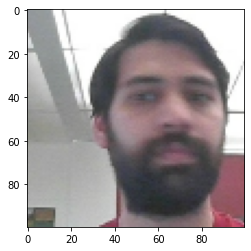

In [30]:
plt.imshow(res[0])

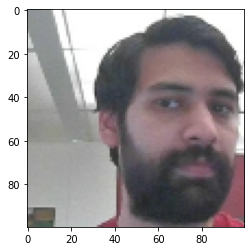

In [31]:
plt.imshow(res[1])

In [32]:
res[2]

1.0

In [33]:
# Build dataloader pipeline
# apply the preprocess_twin function to the data
data = data.map(preprocess_twin) 

# cache the images
data = data.cache()

data = data.shuffle(buffer_size=1024)

In [34]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [35]:
samples = data.as_numpy_iterator()

In [36]:
len(samples.next())

3

In [37]:
samples.next()

(array([[[0.3852941 , 0.34166667, 0.34779412],
         [0.46495098, 0.4002451 , 0.40318626],
         [0.5007353 , 0.41936275, 0.41740197],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],
 
        [[0.41862744, 0.3620098 , 0.37303922],
         [0.47254902, 0.3970588 , 0.40392157],
         [0.5120098 , 0.42794117, 0.4269608 ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],
 
        [[0.4615196 , 0.389951  , 0.3973039 ],
         [0.50441176, 0.42181373, 0.42818627],
         [0.52205884, 0.42181373, 0.4269608 ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],
 
        ...,
 
        [[0.50441176, 0.17696078, 0.27009803],
         [0.5137255 , 0.18284313, 0.27769

In [38]:
samp = samples.next()

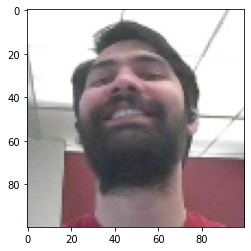

In [39]:
plt.imshow(samp[0])

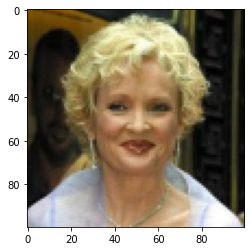

In [40]:
plt.imshow(samp[1])

In [41]:
samp[2] # checking the label for the above example

0.0

In [42]:
round(len(data)*.7)

420

In [43]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [44]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [45]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [46]:
train_samples = train_data.as_numpy_iterator()

In [47]:
train_sample = train_samples.next()

In [48]:
train_sample

(array([[[[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         ...,
 
         [[0.7291667 , 0.7526961 , 0.7526961 ],
          [0.73161

In [49]:
len(train_sample[0])

16

In [50]:
round(len(data)*.3)

180

In [51]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 5. Model Engineering

In [52]:
inp = Input(shape=(100,100,3), name='input_image')

In [53]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [54]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [55]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [56]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [57]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [58]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [59]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [60]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [61]:
embedding = make_embedding()

In [62]:
embedding.summary()


Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

In [63]:
class L1Dist(Layer):
    # Inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Similarity Calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [64]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [65]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [66]:
siamese_layer = L1Dist()

In [67]:
distances = siamese_layer(inp_embedding, val_embedding)

In [68]:
classifier = Dense(1, activation='sigmoid')(distances)

In [69]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [70]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [71]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [72]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [73]:
siamese_model = make_siamese_model()

In [74]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 6. Training

In [75]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [76]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [77]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [78]:
test_batch = train_data.as_numpy_iterator()

In [79]:
batch_1 = test_batch.next()

In [80]:
X = batch_1[:2]

In [81]:
np.array(X).shape

(2, 16, 100, 100, 3)

In [82]:
y = batch_1[2]

In [83]:
y

array([1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0.],
      dtype=float32)

In [84]:
@tf.function
def train_step(batch):
    
    # Record all of our operations
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [85]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [86]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [87]:
EPOCHS = 50

In [88]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 12s 216ms/step
0.30802855 0.36238533 1.0

 Epoch 2/50
27/27 [==============================] - 5s 199ms/step
1.2426275 0.95714283 0.99014777

 Epoch 3/50
27/27 [==============================] - 5s 203ms/step
0.0047183908 0.9764151 0.9904306

 Epoch 4/50
27/27 [==============================] - 6s 205ms/step
0.045911055 0.9860465 0.9860465

 Epoch 5/50
27/27 [==============================] - 6s 203ms/step
0.00051180116 1.0 1.0

 Epoch 6/50
27/27 [==============================] - 5s 195ms/step
1.2815032e-06 0.9951923 1.0

 Epoch 7/50
27/27 [==============================] - 5s 193ms/step
0.0027131047 1.0 1.0

 Epoch 8/50
27/27 [==============================] - 5s 193ms/step
0.00037251582 0.9558824 1.0

 Epoch 9/50
27/27 [==============================] - 5s 194ms/step
0.18426824 

# 7. Evaluate Model

In [89]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [90]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [91]:
y_hat = siamese_model.predict([test_input, test_val])

In [92]:
test_input.shape

(16, 100, 100, 3)

In [93]:
test_val.shape

(16, 100, 100, 3)

In [94]:
np.array(y_hat).shape

(16, 1)

In [95]:
# Post processing the results 
prediction = [1 if prediction > 0.99 else 0 for prediction in y_hat]

In [96]:
prediction

[1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0]

In [97]:
y_true

array([1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
      dtype=float32)

In [98]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [99]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [100]:
test_input.shape

(16, 100, 100, 3)

In [101]:
test_val.shape

(16, 100, 100, 3)

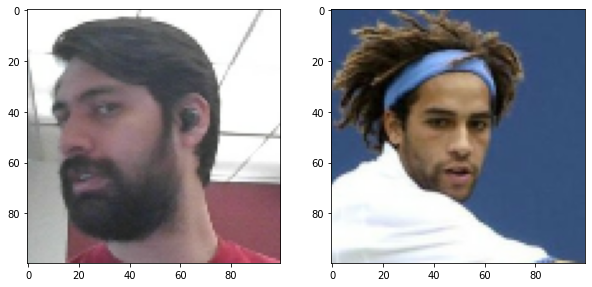

True_Label:0.0 | Predicted Label:0 
Correctly Verified. This is not Jose


In [102]:
# Set plot size 
plt.figure(figsize=(10,8))
i = 14
# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[i])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[i])

# Renders cleanly
plt.show()
if y_true[i] == prediction[i]:
    if y_true[i] == 0:
        print(f"True_Label:{y_true[i]} | Predicted Label:{prediction[i]} \nCorrectly Verified. This is not Kshitij")
    else:
        print(f"True_Label:{y_true[i]} | Predicted Label:{prediction[i]} \nCorrectly Verified. This is Jose")
else:
    print(f"True_Label:{y_true[i]} | Predicted Label:{prediction[i]} \nIncorrect Result")
    if y_true[i] == 1:
        print("\nIt is Jose but NN didn't recognise")
    else:
        print("\nIt is not Jose but NN said so")

# 8. Save Model

In [103]:
# Save weights
siamese_model.save('siamesemodelravi.h5')

In [844]:
# Reload Model
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist': L1Dist, 'BinaryCrossEntropy':tf.losses.BinaryCrossentropy})

In [845]:
model.predict([test_input, test_val])

array([[0.650637  ],
       [0.9997533 ],
       [0.01683607],
       [0.94509387],
       [0.83330166],
       [0.99039346],
       [0.99628216],
       [0.12748298],
       [0.9391172 ],
       [0.9836078 ],
       [0.983288  ],
       [0.7893713 ],
       [0.9987029 ],
       [0.23541255],
       [0.20224473],
       [0.66305584]], dtype=float32)

In [846]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [ ]:
[[1 if prediction > 0.5 else 0 for prediction in i] for i in y_hats ]

In [ ]:
y_trues